# Imports

In [120]:
import hotspice
from hotspice.ASI import IP_Triangle
from hotspice.ASI import IP_Ising_Offset, IP_Ising
from hotspice.io import FieldInputter, RandomBinaryDatastream
import numpy as np
import matplotlib.pyplot as plt
energies = [hotspice.DipolarEnergy(), hotspice.ZeemanEnergy()]
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score 

# Methods

### 1. Field Input 

In [126]:
def run_input(mm: hotspice.Magnets, data=None, input = None, **kwargs):

    """
    Applies input field onto magnetic mm
    Define input chain to be a random array of numbers between 1 and -1
    Works best for pulse_length on the scale of 0.0001 - 0.01[s]
    Returns the magnetization response of the system when input is applied
    
    """
    
    magnetization_data = [] 
    datastream = hotspice.io.RandomIntegerDatastream()
    field = FieldInputter(datastream, magnitude=1, angle=np.pi/2 , n=2, sine=False, frequency=1, half_period=True)

    for i in range(len(input)):
        bit_data = []        
        field.input_zero(mm, value = (input[i]*field_magnitude))     
        bit_start_time = time.perf_counter_ns()
        
        #Apply field in the timeframe within pulse_length
        while time.perf_counter_ns() - bit_start_time < pulse_length:
            mm.update()
            magnetization = np.mean(mm.m)
            magnetization_over_time.append(magnetization)
            field_magnitude_over_time.append((input[i])*field_magnitude)
            time_over_time.append(time.perf_counter_ns() )
            
            #storing magnetization data for each bit
            bit_data.append(magnetization)
        
        magnetization_data.append([input[i]] + bit_data)


    max_length = max(len(row) for row in magnetization_data) 

    #Returns dataframe containing magnetization_data array for all bits in the input chain
    df = pd.DataFrame(magnetization_data, columns=['Field Strength'] + [f'Magnetization_{i}' for i in range(1, max_length)])

    return df, magnetization_over_time

In [88]:
def plot_response(data=None):

    """
    Plots the input field and magnetization response of the system
    """
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    #Converting time into in units of [s]
    time_in_seconds = (np.array(time_over_time) - np.min(time_over_time)) * 1e-9

    ax[0].plot(time_in_seconds, magnetization_over_time, label='Magnetization')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Magnetization')
    ax[0].set_ylim([-1,1])
    ax[0].legend()
    ax[1].plot(time_in_seconds, field_magnitude_over_time, label = 'Field')
    ax[1].set_ylabel('Field magnitude')
    ax[1].set_xlabel('Time [s]')
    plt.suptitle("Average magnetisation over time as field is applied.")
    plt.show()

### 2. Ridge Regression

In [64]:
def rid_reg(df, mem):
    """
    Train the magnetization output to remember mem = n bits in the past. Test the memory performance by ridge regression

    Performs a memory performance analysis using ridge regression to determine how well the system remembers past inputs based on its magnetization response. 
    Takes a df from run_input function containing the field strength and magnetization response for each input bit and a memory parameter (mem), which specifies how far back in the past the function should look. 
    The function shifts the Field Strength column by mem positions to create a new Target column, 
    effectively setting up a regression problem where the goal is to predict the field strength from mem bits ago using the current magnetization response. 
    After cleaning the data, it trains a ridge regression model and evaluates its performance using Mean Squared Error (MSE) and R-squared (R²) metrics. 
    Lower MSE and higher R² values indicate better memory performance, meaning the system retains information about past inputs more effectively. 

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame from run_input function, containing the field magnetude and magnetization response for each bit
    mem : int
        By how many bits to shift the input to create target. Eg. mem = 10 means we are trying to test how well the system remembers 10 bits in the past

    Returns:
    --------
    dff : pd.DataFrame
        The cleaned DataFrame used for regression 
    mse : float
        The mean squared error of the regression model on the test set. A indicator of memory performance
    r2 : float
        The R-squared value of the regression model on the test set. A indicator of memory performance
    y_target : np.array
        The true target values from the test set.
    y_pred : np.array
        The predicted target values from the regression model on the test set.
    """

    #clean dataframe
    df['Target'] = df['Field Strength'].shift(mem) 

    # Reorder the columns to have 'Field Strength' and 'Target' next to each other
    columns = ['Field Strength', 'Target'] + [col for col in df.columns if col not in ['Field Strength', 'Target']]

    df = df[columns]
    
    dff= df
    dff = dff.dropna(subset=['Target'])
    dff= dff.dropna(how='any', axis=1)
    pd.set_option("display.max_rows", None)
    dff
    
    #do the regression
    X = dff.drop(columns=['Field Strength', 'Target'])
    y = dff['Target']

    if dff.shape[0] == 0:
        print(f"Warning: After cleaning, the DataFrame is empty for mem = {mem}. Skipping regression.")
        return dff, None, None, None, None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)    
    ridge_model = Ridge(alpha=0.5,max_iter=5000)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)
    y_target = y_test.values
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    #for debugging, will return warning if not enough magnetization data for regression
    if X.shape[0] < 2:  
        print(f"Warning: Not enough samples to split for mem = {mem}. Skipping regression.")
        return dff, None, None, None, None

    
    return dff, mse, r2, y_target, y_pred



In [22]:
def plot_reg_results(df, mse, r2, y_target, y_pred):

    """
    Plots ridge regression results for a specific mem value

    Parameters:
    -----------
    df, mse, r2, y_target, y_pred from rid_reg()
    
    """
        
    plt.figure(figsize=(15, 6))
    plt.plot(y_target, label="Target", marker='o')
    plt.plot(y_pred, label="Output predicted by ridge regression model", marker='x')
    plt.title(f'Actual and Predicted Target Values (Ridge Regression)\nMSE: {mse:.4f}, R-squared: {r2:.4f}')
    plt.xlabel("Index")
    plt.ylabel("Target Value")
    plt.legend()

    plt.grid(True)
    plt.show()

In [72]:
def plot_mem(df, mem_values):
    
    """
    Test memory performance for a range of mem values 
    Plot the Mean Squared Error (MSE) and R-squared (R²) values as a function of memory size (mem).

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing run_input function, containing the field magnetude and magnetization response for each bit. 
    mem_values : list
        A list of memory sizes to test

    """
    mse_values = []
    r2_values = []

    # Loop over each memory size (mem) in the provided list, do regression for each mem value
    for mem in mem_values:
        dff, mse, r2, y_target, y_pred = rid_reg(df, mem)
        mse_values.append(mse)
        r2_values.append(r2)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(mem_values, mse_values, label='MSE', color='red', marker='o')
    plt.plot(mem_values, r2_values, label='R²', color='blue', marker='o')
    plt.xlabel('Memory Size (mem)')
    plt.ylabel('Values')
    plt.title('MSE and R² vs Memory Size (mem)')
    plt.legend()
    plt.grid(True)
    plt.show()

### 3. Parameter sweep

In [98]:
def T_sweep(T_values, E_B, mem_values, input):
    """
    Run simulations for different temperature values (T) and plot the Mean Squared Error (MSE)
    and R-squared (R²) values as a function of memory size (mem) for each temperature on a single plot.

    Parameters:
    -----------
    T_values : list
        A list of temperature values to run simulations for.
    E_B : int
        fixed E_B value.
    mem_values : list
        A list of memory sizes (shift values) to evaluate for the regression model.
    input_data : np.array
        field input for the ASI system

    Returns:
    --------
    results : dict
        A dictionary containing the DataFrames for each temperature, where the key is the temperature.
    """
    results = {}

    # Run run_input() for each temperature in the provided list
    for T in T_values:
        print(f"Running simulation for E_B = E_B, T = {T}...")

        mm = IP_Ising_Offset(a=280e-9, T=T, E_B=E_B, n=4 * (4 + 1), Msat=800e3, V=4.8e-23, 
                             angle=np.pi/2, pattern="random", energies=hotspice.ZeemanEnergy())

        mm.initialize_m('AFM')  
        mm.history.clear()  

        
        df, magnetization_over_time = run_input(mm, data=None, input=input)

        results[T] = df

    #Plot regression result for each temperature
    plt.figure(figsize=(10, 6))

    # Loop through the results and generate plots for each temperature
    for T, df in results.items():
        
        mse_values = []
        r2_values = []

        # Loop over memory sizes and calculate MSE and R² for each
        for mem in mem_values:
            dff, mse, r2, y_target, y_pred = rid_reg(df, mem)  # Assuming rid_reg returns MSE and R²
            mse_values.append(mse)
            r2_values.append(r2)
        
        plt.plot(mem_values, mse_values, label=f'MSE (E_B= {E_B}, T={T})', linestyle='--')
        plt.plot(mem_values, r2_values, label=f'R² (E_B={E_B}, T={T})', linestyle='-')


    plt.xlabel('Memory Size (mem)')
    plt.ylabel('MSE and R²')
    plt.title('MSE and R² vs Memory Size for different T values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


    return results


In [99]:
def E_B_sweep(E_B_values,T, mem_values, input):
    """
    Run simulations for different energy barrier (E_B) values and plot the Mean Squared Error (MSE)
    and R-squared (R²) values as a function of memory size (mem) for each energy barrier value on a single plot.

    Parameters:
    -----------
    E_B_values : list
        A list of energy barrier (E_B) values to run simulations for.
    T : int
        fixed T value.
    mem_values : list
        A list of memory sizes (shift values) to evaluate for the regression model.
    input_data : np.array
        Field input for the ASI system

    Returns:
    --------
    results : dict
        A dictionary containing the DataFrames for each E_B value, where the key is the E_B value.
    """

    # Dictionary to store the results for each energy barrier (E_B)
    results = {}

    # Loop over each E_B value in the provided list
    for E_B in E_B_values:
        print(f"Running simulation for E_B = {E_B}, T = {T}...")

        # Initialize the IP_Ising_Offset model with the given E_B and a fixed temperature 
        mm = IP_Ising_Offset(a=280e-9, T=T, E_B=E_B, n=4 * (4 + 1), Msat=800e3, V=4.8e-23, 
                             angle=np.pi/2, pattern="random", energies=hotspice.ZeemanEnergy())

        mm.initialize_m('AFM')  
        mm.history.clear()  

        df, magnetization_over_time = run_input(mm, data=None, input=input)
            
        results[E_B] = df


    plt.figure(figsize=(10, 6))

    # Loop through the results and generate plots for each E_B value
    for E_B, df in results.items():
        mse_values = []
        r2_values = []

        # Loop over memory sizes and calculate MSE and R² for each
        for mem in mem_values:
            dff, mse, r2, y_target, y_pred = rid_reg(df, mem)  # Assuming rid_reg returns MSE and R²
            mse_values.append(mse)
            r2_values.append(r2)

        plt.plot(mem_values, mse_values, label=f'MSE (E_B={E_B:.1e}, T={T})', linestyle='--')
        plt.plot(mem_values, r2_values, label=f'R² (E_B={E_B:.1e}, T={T})', linestyle='-')

    plt.xlabel('Memory Size (mem)')
    plt.ylabel('MSE and R²')
    plt.title('MSE and R² vs Memory Size (for different E_B values)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results


# Generating Input Fields

### Sine input fields

In [14]:

def sine_field_generator(length=500, variation_factor=0.1, smooth_factor=0.01):
    """
    Generate a fluctuating sine field with values between -1 and 1. 
    
    Parameters:
    -----------
    length : int, optional
        The length of the array. Default is 500.
    variation_factor : float, optional
        A factor that controls the volatility of the random fluctuations. 
        Higher values lead to more volatile trends. Default is 0.1.
    frequency : float, optional
        A factor that controls the frequencu of the base trend. 

    Returns:
    --------
    sine_field : np.array
        An array of sine graph values with a range between -1 and 1.
    """
    
    #Create a smooth base trend using a sine wave
    time = np.arange(length)
    base_trend = np.sin(time * frequency)  # Smooth sinusoidal base trend
    
    #Generate random fluctuations scaled by the variation factor
    random_fluctuations = np.random.randn(length) * variation_factor

    stock_like_trend = base_trend + random_fluctuations

    #Normalize the trend to be between -1 and 1
    stock = 2 * (stock_like_trend - np.min(stock_like_trend)) / (np.max(stock_like_trend) - np.min(stock_like_trend)) - 1
    
    return sine_field


### Stock like input fields

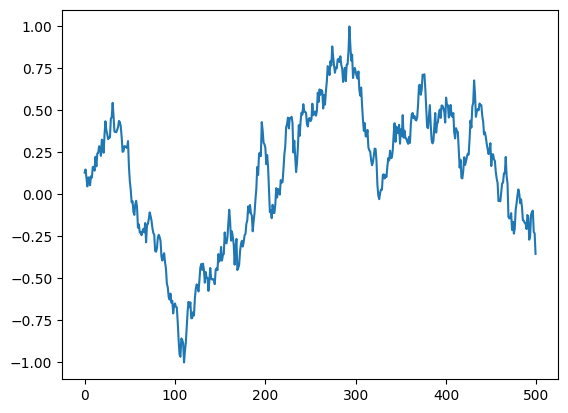

In [109]:
random_fluctuations = np.random.randn(500) * 0.1  # Small random fluctuations
stock_like_trend = np.cumsum(random_fluctuations)

#Normalising between -1 and 1
stock_field = 2 * (stock_like_trend - np.min(stock_like_trend)) / (np.max(stock_like_trend) - np.min(stock_like_trend)) - 1
plt.plot(stock_field)

# Calling

### Visualising magnetization response under an input field

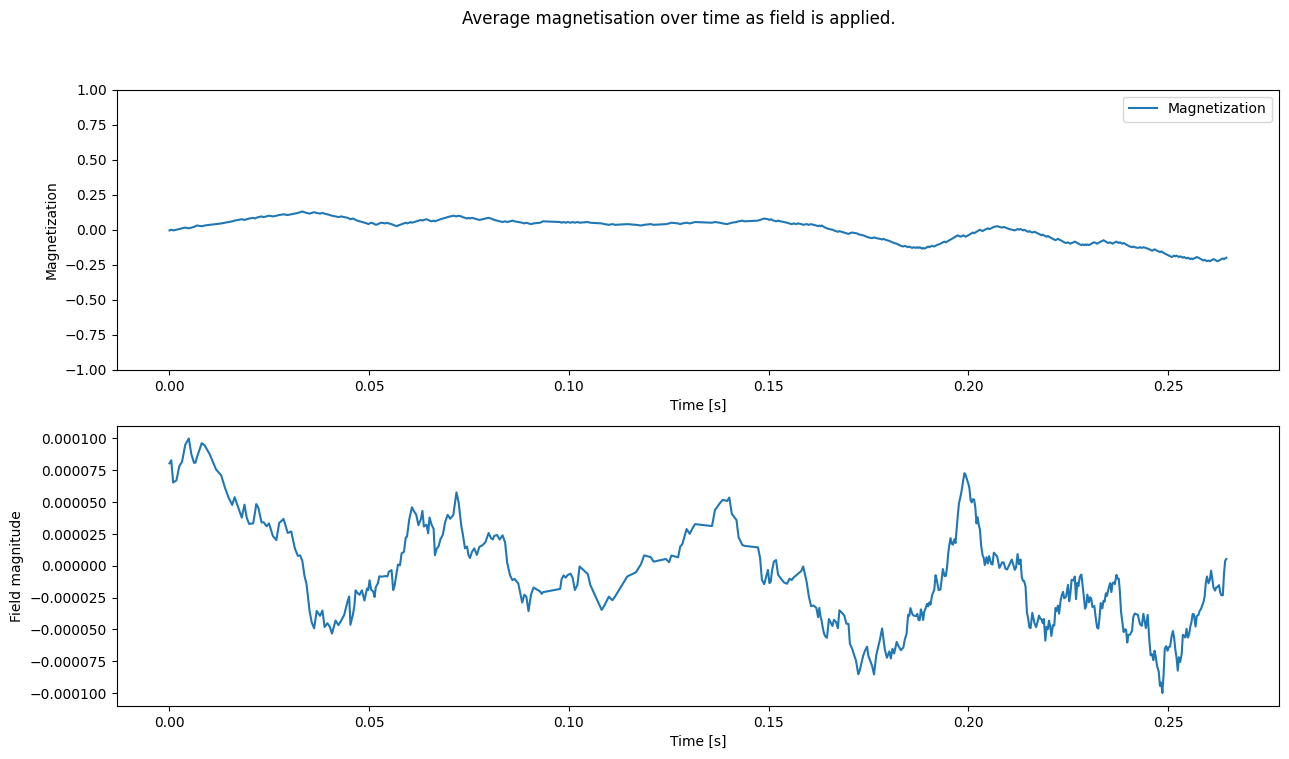

In [127]:
magnetization_over_time = []
field_magnitude_over_time = []
time_over_time = []  # To store the time at each update

mm = IP_Ising_Offset(a = 280e-9, T =300, E_B = 0.5e-19, n = 4 *(4+1),Msat = 800e3,V = 4.8e-23, angle = np.pi/2, pattern = "random", energies = hotspice.ZeemanEnergy())

pulse_length = (0.0001)*1e9 #[s]
field_magnitude = 0.0001


mm.initialize_m('AFM')
mm.history.clear()
df1, magnetization_over_time1  = run_input(mm, data=None, input = stock) 
plot_response(df1)

### Visualising regression

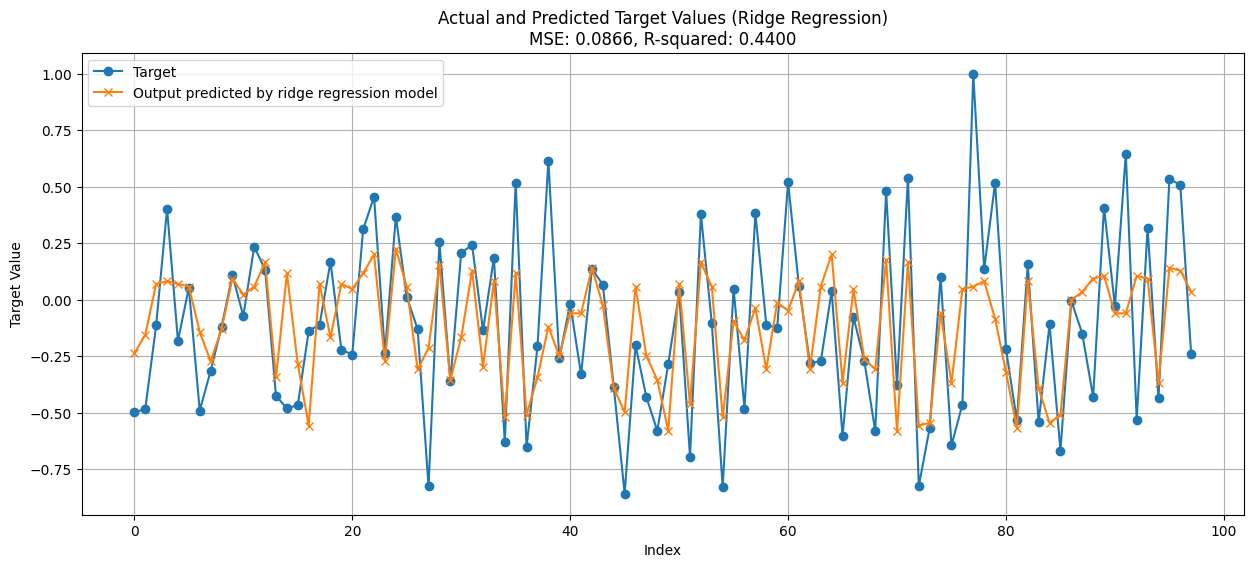

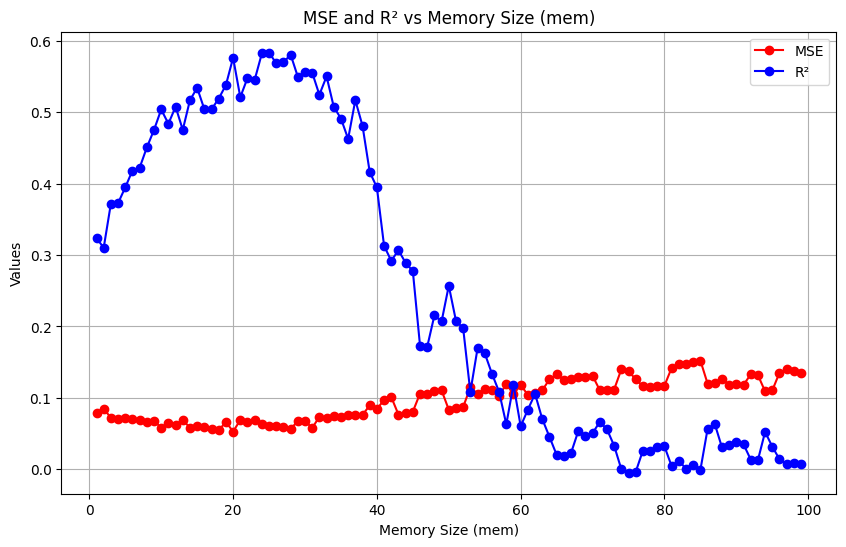

In [128]:
df, mse, r2, y_target, y_pred = rid_reg(df1,mem=10)
plot_reg(df, mse, r2, y_target, y_pred)

mem_values = list(range(1, 100)) 

plot_mem(df, mem_values)

### E_B Sweep

Running simulation for E_B = 1e-20, T = 300...
Running simulation for E_B = 1e-21, T = 300...
Running simulation for E_B = 5e-22, T = 300...
Running simulation for E_B = 3e-22, T = 300...
Running simulation for E_B = 1e-22, T = 300...


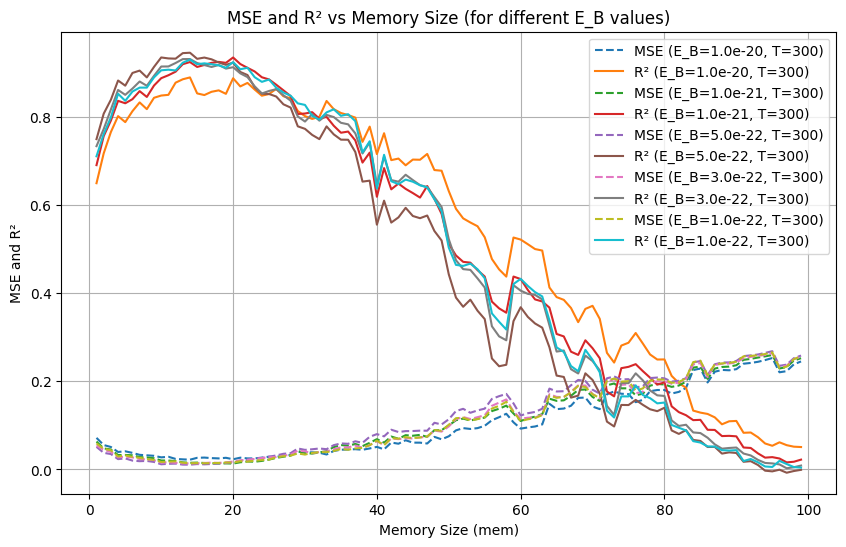

In [105]:
magnetization_over_time = []
field_magnitude_over_time = []
time_over_time = []  # To store the time at each update

pulse_length = (0.001)*1e9 #[s]
field_magnitude = 0.0001

E_B_values = [1e-20, 1e-21,0.5e-21, 0.3e-21, 0.1e-21]  

mem_values = list(range(1, 100))

# Run the simulations for the given ranges of E_B and T
results = E_B_sweep(E_B_values, 300, mem_values, input=stock_field)



### T Sweep

Running simulation for E_B = E_B, T = 250...
Running simulation for E_B = E_B, T = 300...
Running simulation for E_B = E_B, T = 350...
Running simulation for E_B = E_B, T = 400...
Running simulation for E_B = E_B, T = 450...


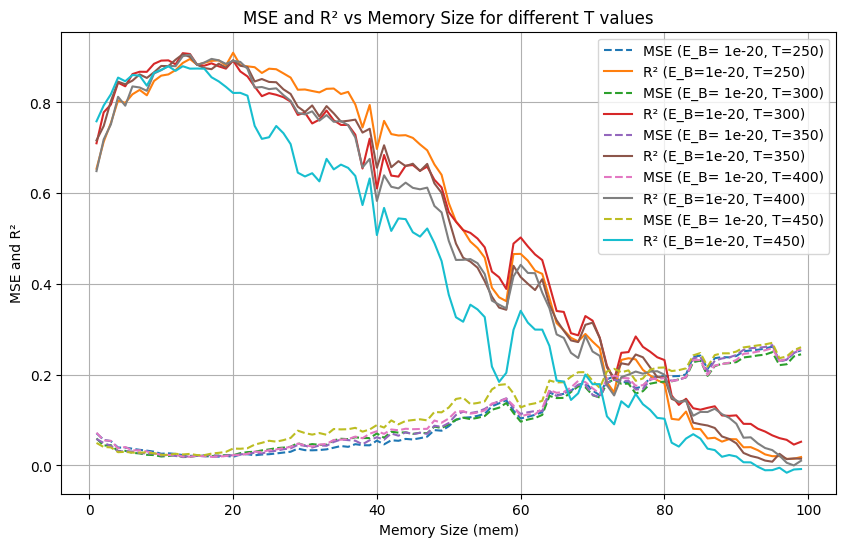

In [106]:
magnetization_over_time = []
field_magnitude_over_time = []
time_over_time = []  # To store the time at each update

pulse_length = (0.001)*1e9 #[s]
field_magnitude = 0.0001

T_values = [250, 300,350, 400, 450]  
E_B=1e-20
mem_values = list(range(1, 100))

# Run the simulations for the given ranges of E_B and T
results = T_sweep(T_values, E_B, mem_values, input=stock_field)